In [24]:
# --- Imports ---
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

from src import load_bcn20000, get_transforms

In [25]:
# --- Load datasets ---
train_hf = load_bcn20000(split="train")
val_hf = load_bcn20000(split="validation")
test_hf = load_bcn20000(split="test")

label_names = train_hf.features["label"].names
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {i: name for name, i in label2id.items()}

(len(train_hf), len(val_hf), len(test_hf), label_names)

(12413, 1240, 6501, ['female', 'male', 'nan'])

In [26]:
# --- Torch wrapper around HF dataset ---
class TorchImageDataset(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.tf = transform
        self.label_feature = hf_ds.features["label"]

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.open(img).convert("RGB")
        x = self.tf(img)
        y = ex["label"]
        if isinstance(y, str):
            y = self.label_feature.str2int(y)
        else:
            y = int(y)
        return x, y

In [27]:
# --- Build transformed datasets ---
train_tf = get_transforms(train=True)
eval_tf = get_transforms(train=False)

train_ds = TorchImageDataset(train_hf, train_tf)
val_ds = TorchImageDataset(val_hf, eval_tf)
test_ds = TorchImageDataset(test_hf, eval_tf)

In [28]:
# --- Create DataLoaders ---
batch_size = 16

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
images.shape, labels.shape, labels[:8].tolist()

(torch.Size([16, 3, 224, 224]), torch.Size([16]), [0, 0, 1, 0, 0, 1, 0, 1])

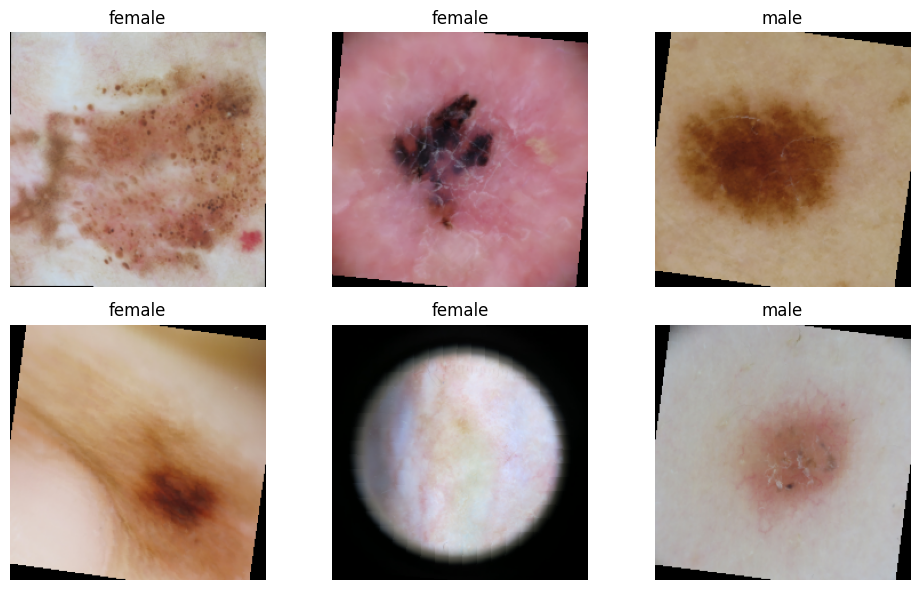

In [29]:
# --- Visualize sample batch ---
def show_grid(tensors, targets, n=6):
    n = min(n, tensors.size(0))
    fig, axes = plt.subplots(2, (n + 1) // 2, figsize=(10, 6))
    axes = axes.flatten()
    for i in range(n):
        img = tensors[i].detach().cpu()
        img = (img * 0.5) + 0.5
        img = img.permute(1, 2, 0).clamp(0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f"{id2label[int(targets[i])]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

show_grid(images, labels, n=6)

In [30]:
# --- Save label mappings for later ---
import json, os
os.makedirs("../artifacts", exist_ok=True)
with open("../artifacts/labels.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f)

len(label2id), list(label2id)[:5]

(3, ['female', 'male', 'nan'])